# Creates input for Gat2Vec using STRING

In this notebook we add the disease-gene association information, obtained from PheWAS Catalog, to the GuiltyTargets pipeline. The run is tested using STRING PPI network and AMP-AD MSBB gene expression data (Brodmann area 10).

## Imports and definitions

In [1]:
import warnings

import itertools
import os

import bio2bel_phewascatalog
from GAT2VEC.gat2vec import Gat2Vec
from guilty_phewas import pulearn
from guilty_phewas.string_ppi_assembler import StringAssembler
from guilty_phewas.utils import generate_phewas_file
from guiltytargets.constants import gat2vec_config
from guiltytargets.pipeline import rank_targets
from guiltytargets.ppi_network_annotation.parsers import parse_association_scores, parse_gene_list
import matplotlib.pyplot as plt
import pandas as pd
from guiltytargets.ppi_network_annotation import AttributeNetwork, LabeledNetwork, Network, generate_ppi_network, \
    parse_dge

# For AD

In [2]:
# Suppress warnings
warnings.simplefilter('ignore')

targets_file = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\ot_entrez.txt'
assoc_file = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\ot_assoc.txt'
# file generated by the script src\r_scripts\DiffExpr.R
input_path = r'C:\Users\Mauricio\Thesis\DGE data\AMP-AD'
dge_path = r'C:\Users\Mauricio\Thesis\DGE data\AMP-AD\DifferentialExpression_BM22.csv'
data_dir = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks'
phewas_path = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\phewas.txt'
string_path = os.path.join(data_dir, 'string.edgelist')

graph_paths = [string_path]
lfc_cutoffs = [0.5, 1.0, 1.5]
confidence_cutoffs = [0.0, 0.63]

# for differential expression
max_padj = 0.05
base_mean_name = 'baseMean' or None  # it was None
log_fold_change_name = 'log2FoldChange'
adjusted_p_value_name = 'padj'
entrez_id_name = 'symbol'
split_char = '///'
diff_type = 'all'

### Filter the columns from the STRING file

In [3]:
assembler = StringAssembler()
assembler.create_adj_file()


### Gene disease associations

In [4]:
generate_phewas_file(phewas_path)

PheWAS Catalog - generating Dict: 100%|██████████████████████████████████████| 215107/215107 [00:21<00:00, 9795.00it/s]


In [3]:
gene_list = parse_dge(
    dge_path=dge_path,
    entrez_id_header=entrez_id_name, 
    log2_fold_change_header=log_fold_change_name,
    adj_p_header=adjusted_p_value_name,
    entrez_delimiter=split_char,
    base_mean_header=base_mean_name,
)

Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.9702829349948182
C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\string.edgelist 1.5 0.0
    accuracy   f1micro   f1macro       auc
TR                                        
0   0.992452  0.992452  0.576571  0.951249
1   0.992918  0.992918  0.596817  0.945022
2   0.992659  0.992659  0.582436  0.943791
3   0.992608  0.992608  0.584448  0.947989
4   0.992659  0.992659  0.572015  0.946639
5   0.992711  0.992711  0.589635  0.948600
6   0.992608  0.992608  0.581746  0.946172
7   0.992659  0.992659  0.579110  0.949222
8   0.992711  0.992711  0.593907  0.948564
9   0.992918  0.992918  0.599440  0.943977
Initializing g

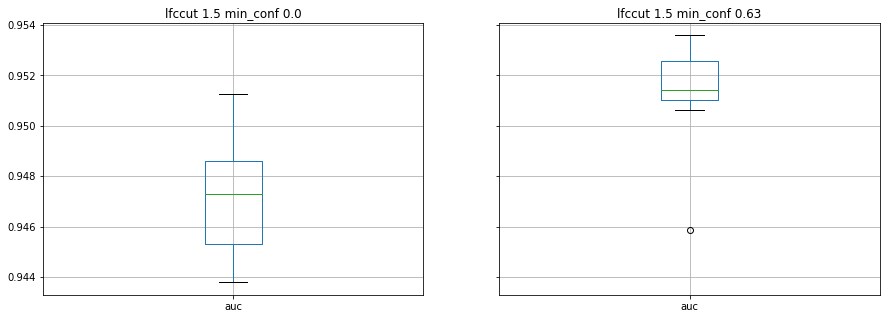

In [4]:
%%time

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,#
        current_disease_ids_path='',
        disease_associations_path=phewas_path, #
    )

    targets = parse_gene_list(targets_file, network.graph)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    
    print(ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence)
    # print(auc_df)
    auc_df.boxplot(column=['auc'], ax=axs[axs_ind])
    axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1
    


PheWAS 0.5 0.0
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.9760407779859224

no PheWAS 0.5 0.0
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.9752120710309984

PheWAS 0.5 0.63
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\

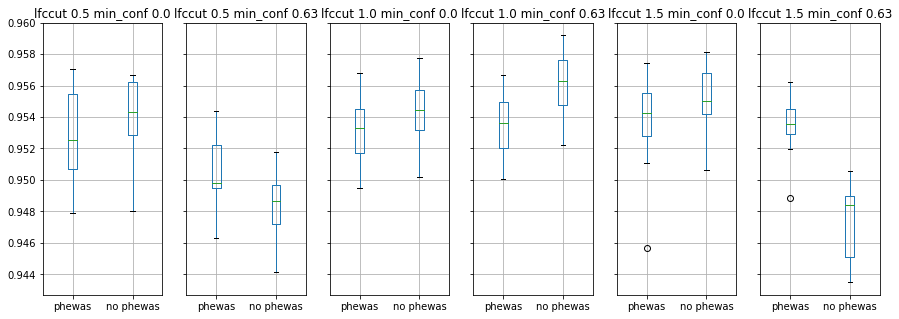

In [4]:
%%time
# COMPARE WITH AND W/O PHEWAS

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    df = pd.DataFrame()
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    print('\nPheWAS', lfc_cutoff, ppi_edge_min_confidence)
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,#
        current_disease_ids_path='', 
        disease_associations_path=phewas_path, #
    )

    targets = parse_gene_list(targets_file, network.graph)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    df['phewas'] = auc_df['auc']
    
    # print('PheWAS', lfc_cutoff, ppi_edge_min_confidence)
    # print(auc_df)  
    
    print('\nno PheWAS', lfc_cutoff, ppi_edge_min_confidence)
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,# 
        # disease_associations_path=phewas_path, # no phewas
    )

    targets = parse_gene_list(targets_file, network.graph)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    df['no phewas'] = auc_df['auc']
    
    # print('no PheWAS', lfc_cutoff, ppi_edge_min_confidence)
    # print(auc_df)
    
    df.boxplot(column=['phewas', 'no phewas'], ax=axs[axs_ind])
    axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1
    

## Comparison with the weighted penalized logistic regression

Weighted RR
pt 1
Ridge Regression
C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\string.edgelist 1.5 0.0
Weighted RR
pt 1
Ridge Regression
C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\string.edgelist 1.5 0.63
Wall time: 31min 10s


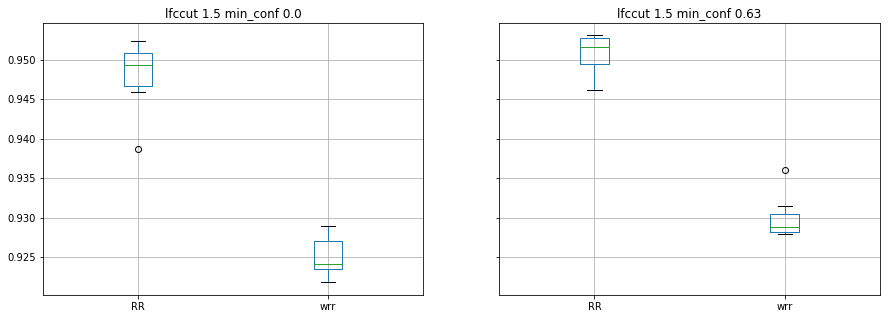

In [4]:
%%time

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    df = pd.DataFrame()
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    print("Weighted RR")
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,#
        current_disease_ids_path='',
        disease_associations_path=phewas_path, #
    )
    
    targets = parse_gene_list(targets_file, network.graph)
    
    # Uses the files saved by `rank_targets` at `input_path`
    assoc_score = assoc_file and parse_association_scores(assoc_file)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
        assoc_score=assoc_score
    )
    df['wrr'] = auc_df['auc']

    print("Ridge Regression")
    
    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    print(ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence)
    df['RR'] = auc_df['auc']
    
    df.boxplot(column=['RR', 'wrr'], ax=axs[axs_ind])
    axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1


## Comparison with the biased SVM (no sample weights)

Ridge Regression
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.9747781403844669
C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\string.edgelist 1.5 0.0
Biased SVM
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
1
2
3
guilty_phewas.pulearn get_biased_predictions
4
5
6
7
8
guilty_phewas.pulearn evaluate_bsvm - TR 0
3
guilty_phewas.pulearn get_biased_predicti

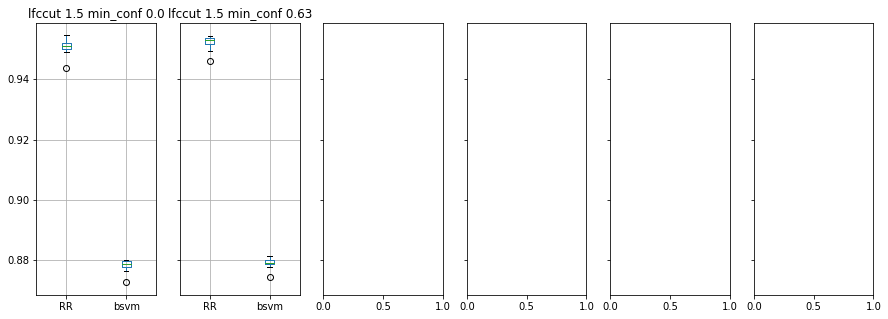

In [4]:
%%time

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

# Reduce the number of iterations
lfc_cutoffs = [1.5]

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    df = pd.DataFrame()
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    print("Ridge Regression")
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,#
        current_disease_ids_path='',
        disease_associations_path=phewas_path, #
    )
    targets = parse_gene_list(targets_file, network.graph)
    
    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    print(ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence)
    df['RR'] = auc_df['auc']
    
    print("Biased SVM")
    
    # Uses the files saved by `rank_targets` at `input_path`
    g2v = Gat2Vec(input_path, input_path, label=False, tr=gat2vec_config.training_ratio)
    model = g2v.train_gat2vec(
        gat2vec_config.num_walks,
        gat2vec_config.walk_length,
        gat2vec_config.dimension,
        gat2vec_config.window_size,
        output=True,
    )
    pul = pulearn.PULearn(input_path, input_path, tr=gat2vec_config.training_ratio)
    auc_df = pul.evaluate(model, label=False, evaluation_scheme="bsvm")
    df['bsvm'] = auc_df['auc']


    df.boxplot(column=['RR', 'bsvm'], ax=axs[axs_ind])
    axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1


In [23]:
plt.show()

# For Acute Myeloid  leukemia (AML) 

In [2]:
# Suppress warnings
warnings.simplefilter('ignore')

targets_file = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\ot_entrez.txt'
assoc_file = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\ot_assoc.txt'
# file generated by the script src\r_scripts\DiffExpr.R
input_path = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml'
dge_path = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\DifferentialExpression.tsv'
data_dir = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks'
phewas_path = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\phewas.txt'
string_path = os.path.join(data_dir, 'string.edgelist')

graph_paths = [string_path]
lfc_cutoffs = [0.5, 1.0, 1.5]
confidence_cutoffs = [0.0, 0.63]

# for differential expression
max_padj = 0.05
base_mean_name = None  # it was None
log_fold_change_name = 'logFC'
adjusted_p_value_name = 'adj.P.Val'
entrez_id_name = 'Gene.symbol'
split_char = '///'
diff_type = 'all'

In [9]:
import guilty_phewas.utils as phewas_utils

phewas_utils.download_for_disease('EFO_0000222', targets_file)
phewas_utils.get_association_scores('EFO_0000249', assoc_file)

querying 1-284...done.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5707...done.


In [3]:
gene_list = parse_dge(
    dge_path=dge_path,
    entrez_id_header=entrez_id_name, 
    log2_fold_change_header=log_fold_change_name,
    adj_p_header=adjusted_p_value_name,
    entrez_delimiter=split_char,
    base_mean_header=base_mean_name,
)

In [ ]:
%%time

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

lfc_cutoffs = [1.5]
confidence_cutoffs = [0.63]

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,# 
        current_disease_ids_path='',
        disease_associations_path=phewas_path, #
    )

    targets = parse_gene_list(targets_file, network.graph)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    
    print(ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence)
    # print(auc_df)
    #auc_df.boxplot(column=['auc'], ax=axs[axs_ind])
    #axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1
    

# of targets: 281
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\aml_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\aml_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.953138899057872
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\aml_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\aml_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.9513081087377814
# of targets: 281
Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\aml\aml_graph.adjlist
Number of nodes: 19344
loadi

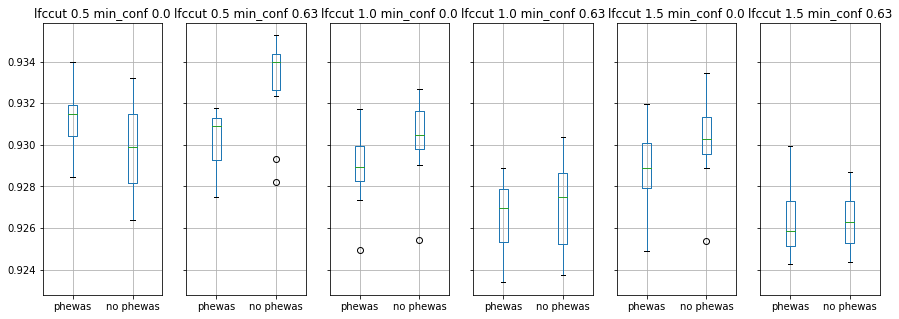

In [7]:
%%time
# COMPARE WITH AND W/O PHEWAS

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    df = pd.DataFrame()
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,# 
        current_disease_ids_path='',
        disease_associations_path=phewas_path, #
    )

    targets = parse_gene_list(targets_file, network.graph)
    print(f'# of targets: {len(targets)}')

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    df['phewas'] = auc_df['auc']
    
    # print('PheWAS', lfc_cutoff, ppi_edge_min_confidence)
    # print(auc_df)    
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,# 
        # disease_associations_path=phewas_path, # no phewas
    )

    targets = parse_gene_list(targets_file, network.graph)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    df['no phewas'] = auc_df['auc']
    
    # print('no PheWAS', lfc_cutoff, ppi_edge_min_confidence)
    # print(auc_df)
    
    df.boxplot(column=['phewas', 'no phewas'], ax=axs[axs_ind])
    axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1

## Comparison with the biased SVM (no sample weights)

In [ ]:
dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

# Reduce the number of iterations
lfc_cutoffs = [1.5]

axs_ind = 0

ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence = graph_paths[0], lfc_cutoffs[0], confidence_cutoffs[0]

max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1

%%time
print("Biased SVM")

# Uses the files saved by `rank_targets` at `input_path`
g2v = Gat2Vec(input_path, input_path, label=False, tr=gat2vec_config.training_ratio)
model = g2v.train_gat2vec(
    gat2vec_config.num_walks,
    gat2vec_config.walk_length,
    gat2vec_config.dimension,
    gat2vec_config.window_size,
    output=True,
)
pul = pulearn.PULearn(input_path, input_path, tr=gat2vec_config.training_ratio)


## Comparison with the weighted penalized logistic regression

In [ ]:
%%time

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(15, 5)

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    df = pd.DataFrame()
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    print("Weighted RR")
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,#
        current_disease_ids_path='',
        disease_associations_path=phewas_path, #
    )
    
    targets = parse_gene_list(targets_file, network.graph)
    
    # Uses the files saved by `rank_targets` at `input_path`
    assoc_score = assoc_file and parse_association_scores(assoc_file)

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
        assoc_score=assoc_score
    )
    df['wrr'] = auc_df['auc']

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    print(ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence)
    df['RR'] = auc_df['auc']
    
    df.boxplot(column=['RR', 'wrr'], ax=axs[axs_ind])
    axs[axs_ind].set_title(f'lfccut {lfc_cutoff} min_conf {ppi_edge_min_confidence}')
    axs_ind += 1
